# Getting back into fastai with fastbook

Started nb on 27 April 2021. The goal of this nb is to ease back in to python and fastai, and to use these muscles so that I don't forget them.

The task of fastbook chapter 4 is to build a binary classifier for image data without using the fastai convenience functions (except towards the end).

# Explore data

In [ ]:
from fastai.vision.all import *

In [ ]:
set_seed(42)

Explore file structure and a random image from the three's dataset.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path # set the BASE_PATH to the data path for readability
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
tensor(im3)[:10,:10]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224],
        [  0,   0,   0,   0,   0,  93, 244, 249, 253, 187],
        [  0,   0,   0,   0,   0, 107, 253, 253, 230,  48],
        [  0,   0,   0,   0,   0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
im3t = tensor(im3)
df = pd.DataFrame(im3t[:20,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0


# Datasets and DataLoader

Stack all of the images for each category into a tensor of (#ims, img_w, img_h).

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

In [ ]:
three_train = torch.stack(three_tensors).float()/255
seven_train = torch.stack(seven_tensors).float()/255
three_train.shape

torch.Size([6131, 28, 28])

Create validation sets.

In [ ]:
three_valid = torch.stack([tensor(Image.open(o)) for o in threes]).float()/255
seven_valid = torch.stack([tensor(Image.open(o)) for o in sevens]).float()/255

### Broadcasting review...

Element-wise operations: elements in memory are matched up.

In [ ]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

Broadcasting: since there aren't enough elements on the left to match up with the tensor on the right, the tensor is copied as many times as necessary, then they're matched up and computed. When broadcasting, the copies are NOT stored in memory, so the computation is lightning-fast.

In [ ]:
tensor([[1,2],[3,4],[5,6]]) - tensor([1,1])

tensor([[0, 1],
        [2, 3],
        [4, 5]])

### ... Back to building the datasets.

Recap of what we've done so far:
- Created four rank 3 tensors: `three_train`, `seven_train`, `three_valid`, and `seven_valid`.
- Each of those tensors is a stack of rank 2 tensors (black and white images of 28x28 pixels).

What we need to do to build a ds:
- We need a training ds and a validation ds.
- Each ds is a list of tensor tuples (x_i, y_i), s.t. each x_i is an img and each y_i is its label.
- The labels will be a 0 or a 1 b/c this is a binary classifier. We'll assign 0 to sevens and 1 to threes.

The images in the dataset will be rearranged as one single row of 28*28=784 pixels.

In [ ]:
train_x = torch.cat([three_train, seven_train]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

*12,396 rows and 784 columns*

In [ ]:
train_y = tensor([1]*len(three_train) + [0]*len(seven_train)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

*12,396 rows and 1 column*

Create pytorch dataset for training data.

Datasets are defined as:
- being indexable w/[idx]
- returns a tuple of (x,y)

Said together, indexing into a dataset returns an (x,y) tuple.

In [ ]:
ds = list(zip(train_x, train_y))
x,y = ds[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Now to do the same thing for the valid_ds.

In [ ]:
valid_x = torch.cat([three_valid, seven_valid]).view(-1, 28*28)
valid_y = tensor([1]*len(three_valid) + [0]*len(seven_valid)).unsqueeze(1)
valid_ds = list(zip(valid_x, valid_y))

### dl

A DataLoader is a more complex class than a dataset with more to its definition. What we'll focus on right now is that a DataLoader is an iterable object that knows how to give data to a learner object for training with minibatches.

Turning the ds into a dl is simple.

In [ ]:
dl = DataLoader(ds, batch_size=256)

xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=256)

# Arch

The model is going to have a single layer. It will be the linear function weights*pixels + bias, with pixels being the image tensors.

We'll create a function to initialize the "weights" and "bias" params.

In [ ]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [ ]:
weights = init_params((28*28, 1))
bias = init_params(1)

Let's get a prediction from the untrained model.

In [ ]:
(train_x[0] * weights.T).sum() + bias

tensor([1.1245], grad_fn=<AddBackward0>)

Calc all the preds.

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 1.1245],
        [-0.6244],
        [-1.7694],
        ...,
        [-5.7155],
        [ 6.7712],
        [ 1.7582]], grad_fn=<AddBackward0>)

How did we do?

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]])

In [ ]:
corrects.float().mean().item()

0.48297837376594543

As expected – random weights = random guess... coin toss! Perfect.

# Loss

Now, to make a loss function. This candidate function will return the correctness-adjusted confidence:

In [ ]:
def conf_weighted_acc(preds, targs): return torch.where(targs==1, 1-preds, preds).mean()

It will only work on numbers between 0 and 1. We'll transform the model outputs with sigmoid.

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Together:

In [ ]:
def loss_fxn(preds, targs): return conf_weighted_acc(preds.sigmoid(), targs)

# Learner?

Re-init params.

In [ ]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fxn(preds, yb)
    loss.backward()

In [ ]:
def train_epoch(dl, model, lr, params):
    for xb,yb in dl: # for each bundle of ims and labels
        calc_grad(xb, yb, model) # calc the grad given by the pred of the model
        for p in params: # for each param (our params are the weights and bias)
            p.data -= p.grad*lr # adjust the param
            p.grad.zero_() # then reset its grad to zero so we can do it again

In [ ]:
def batch_acc(preds, yb):
    probs = preds.sigmoid()
    corr = (probs>0.5) == yb
    return corr.float().mean()

Test batch_acc:

In [ ]:
weights = init_params((28*28, 1))
bias = init_params(1)

xb, yb = first(dl)
preds = linear1(xb)
batch_acc(preds, yb)

tensor(0.4062)

In [ ]:
def epoch_acc(model):
    accs = [batch_acc(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

epoch_acc on the untrained model will give us our starting accuracy.

In [ ]:
epoch_acc(linear1)

0.5468

Let's run an iteration!

In [ ]:
lr = 1.
params = weights, bias
train_epoch(dl, linear1, lr, params)
epoch_acc(linear1)

0.6894

It worked! Let's do 20 more!

In [ ]:
for i in range(20):
    train_epoch(dl, linear1, lr, params)
    print(epoch_acc(linear1), end=' ')

0.8432 0.9056 0.9302 0.942 0.9511 0.9546 0.9578 0.9606 0.9631 0.9648 0.9664 0.9677 0.9692 0.9699 0.9709 0.9717 0.9726 0.9735 0.9744 0.9757 

# Adding in functionality from pytorch and fastai

In [ ]:
model = nn.Linear(28*28, 1)

In [ ]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def move_a_step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def clear_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(model.parameters(), lr)

In [ ]:
def train_epoch(dl, model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.move_a_step()
        opt.clear_grad()

In [ ]:
def train_model(dl, model, epochs):
    for i in range(epochs):
        train_epoch(dl, model)
        print(f"{i}: {epoch_acc(model)}")

Let's recreate the model and the opt and run it!

In [ ]:
model = nn.Linear(28*28, 1)
opt = BasicOptim(model.parameters(), lr)
train_model(dl, model, 20)

0: 0.4888
1: 0.7659
2: 0.85
3: 0.9063
4: 0.9319
5: 0.9462
6: 0.9538
7: 0.9592
8: 0.9647
9: 0.9684
10: 0.9711
11: 0.9729
12: 0.9742
13: 0.9752
14: 0.9762
15: 0.9768
16: 0.9778
17: 0.9782
18: 0.9792
19: 0.9798


Now let's train using fastai's build in optimizer SGD.

In [ ]:
mod = nn.Linear(28*28, 1)
opt = SGD(mod.parameters(), lr)
# train_model(dl, mod, 20)
"""Outputs an error!"""

'Outputs an error!'

Oops! We have to rename the method calls in train_model to match the fastai methods.

In [ ]:
def train_epoch(dl, model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
mod = nn.Linear(28*28, 1)
opt = SGD(mod.parameters(), lr)
train_model(dl, mod, 20)

0: 0.4888
1: 0.944
2: 0.7274
3: 0.876
4: 0.9171
5: 0.9381
6: 0.9489
7: 0.9555
8: 0.9615
9: 0.9661
10: 0.9695
11: 0.9715
12: 0.9734
13: 0.9743
14: 0.9754
15: 0.9764
16: 0.9773
17: 0.9782
18: 0.9783
19: 0.9793


# Building a simple nn

To go from our simple linear model to a nn, we need to add a non-linear component to our model.

Here's what we'll do:
- Use a linear layer that inputs 28*28 pix and outputs 30 numbers.
- For each of those 30 numbers, set the ones less than or equal to 0 to 0.
- Use a final linear layer that inputs 30 numbers and outputs 1.

Some notes:
- Why 30? Well, why not? lol
- The middle step is the ReLU function
- Note that the input to each step is the output of the layer above it.

In [ ]:
mod = nn.Sequential(
  nn.Linear(28*28, 30),
  nn.ReLU(),
  nn.Linear(30, 1))

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learner = Learner(dls, mod, opt_func=SGD, loss_func=loss_fxn, metrics=batch_acc)

In [ ]:
learner.fit(40, lr=lr)

epoch,train_loss,valid_loss,batch_acc,time
0,0.189695,0.489009,0.505405,00:00
1,0.091960,0.262529,0.741772,00:00
2,0.045190,0.119872,0.885286,00:00
3,0.027697,0.084465,0.919410,00:00
4,0.019914,0.067529,0.935544,00:00
5,0.016098,0.057639,0.944982,00:00
6,0.014057,0.051363,0.950871,00:00
7,0.012778,0.046887,0.954905,00:00
8,0.011832,0.043525,0.958535,00:00
9,0.011044,0.040772,0.961520,00:00


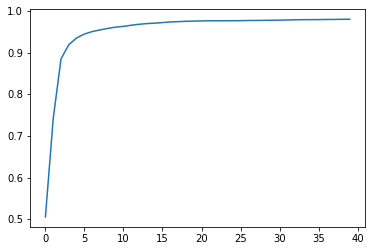

In [ ]:
plt.plot(L(learner.recorder.values).itemgot(2));

In [ ]:
learner.recorder.values[-1][2]

0.9804775714874268

# Where we're going

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy,
                    metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.094167,0.011750,0.996565,00:05


Finished 29 Apr 2021.